#### grid '.44'  compare annual object frequency of CMIP6  runs with era5
 - 'Evaluation': 1979-2010, 3 datasets 
 - 'Historical': 1950-2004 5 datasets 
 - 'RCP': 2006-2099 5 datasets 

In [1]:
import os
import datetime
import numpy as np
from netCDF4 import Dataset
import pandas as pd
 
import string
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy 
import cartopy.crs as ccrs

In [2]:
def read_objs(res_TarGrid, res, nx, ny, type_s):
    '''
    res_TarGrid = '44'
    res  = '44'
    type_s = 'evaluation', 'historical' or 'rcp'
    return:
    dataset: dataset names 
    ObjectFrequency: objects' annual frequency(n_dataset, nx, ny, n_obj)
    '''
    
    sPlotFile = '/glade/u/home/mingge/EURO-CORDEX/'
    dir_0  = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/data/ProcessIdentification/CORDEX/' 
    dir_i = dir_0 + 'TarGrid.'+ str(res_TarGrid)+ '/'+ 'EUR-'+ res +'/annual_feature_frequ/'

    flnm = '/glade/u/home/mingge/EURO-CORDEX/TXT/uniqueVar_?hr_'+ res +'.txt' 
    cmd_ls = 'grep  ' + type_s + ' ' + flnm + ' > flnm_tmp'
    os.system(cmd_ls)

    file = open('flnm_tmp', 'r')
    dataset = file.readlines()
    
    nn = 0
    for line in dataset:
       dataset[nn] = line.replace('\n', '')
       nn = nn + 1

    n_ds = len(dataset)
    os.system('rm flnm_tmp')
    #print('working on ' + str(n_ds) + ' datasets:')
    #print(dataset)
     
    nn_ds = 0
    for ds in dataset:
        flnm_tmp = ds + '.tmp'
        # ls  Sort entries alphabetically if none of -cftuvSUX nor --sort is specified.
        cmd_ls = 'ls -1 ' + dir_i + '*' + ds + '*.npz > ' + flnm_tmp
        os.system(cmd_ls)
    
        with open(flnm_tmp) as ff:
            flnm_t = ff.readlines()
            n_year = len(flnm_t)
            annualObjectFrequency = np.zeros((n_year, nx, ny, n_obj))
            annualObjectFrequency[:] = np.nan
        
            nn = 0
            for line in flnm_t:
                flnm_t[nn] = line.replace('\n', '')
                YYYY = flnm_t[nn].split('/')[-1][:4]
                #print(YYYY,nn, flnm_t[nn])
            
                try:
                    flnm = flnm_t[nn].replace('\n', '')
                except:
                    print('last line', nn)
                    flnm = flnm_t[nn]
                 
                #print('---',flnm,'--')
                DATA = np.load(flnm)
            
                mean_cy = DATA['mean_cy']
                mean_acy = DATA['mean_acy']
                mean_pr = DATA['mean_pr']
                mean_anvil = DATA['mean_anvil']
                mean_fr = DATA['mean_fr']
                mean_ar = DATA['mean_ar']
                mean_ms =  DATA['mean_ms']
                
                #print('Collect the annual frequency of objects')
                annualObjectFrequency[nn,:,:,Objects.index('Cyclones')] = mean_cy
                annualObjectFrequency[nn,:,:,Objects.index('Anticyclones')] = mean_acy
                annualObjectFrequency[nn,:,:,Objects.index('Precipitation')] = mean_pr
                annualObjectFrequency[nn,:,:,Objects.index('Anviles')] = mean_anvil
                annualObjectFrequency[nn,:,:,Objects.index('Fronts')] = mean_fr
                annualObjectFrequency[nn,:,:,Objects.index('AR')] = mean_ar
                annualObjectFrequency[nn,:,:,Objects.index('MS')] = mean_ms

                nn = nn + 1
                
        frequency_4d = np.nanmean(annualObjectFrequency, axis = 0).reshape((1,nx, ny, n_obj))
        # annual average
        if nn_ds == 0:
            ObjectFrequency = frequency_4d  
        else:
            ObjectFrequency = np.append(ObjectFrequency, frequency_4d, axis = 0)     
        nn_ds = nn_ds + 1   
        os.system('rm ' + flnm_tmp)
    return dataset, ObjectFrequency*365

In [3]:
def plot_obj(res, type_s, dataset, ObjectFrequency):
    '''
    res: '44' or '11'
    type_s = 'evaluation', 'historical' or 'rcp'
    dataset: list of dataset name('ECMWF-ERAINT_evaluation_r1i1p1_CLMcom-CCLM5-0-6',
             'ECMWF-ERAINT_evaluation_r1i1p1_UCAN-WRF331G',...)
    ObjectFrenquency: np.zeros((n_dataset,nx, ny, n_obj)
    '''
    MIN     = [   4,         4,              1,            3,          1,    .1,   2]
    Objects = ['Cyclones','Anticyclones','Precipitation','Anviles','Fronts','AR', 'MS'] 

    level_s = [np.arange(0,100, 10), np.arange(0,140, 10), np.arange(0,12,1), np.arange(0, 60,6)
             , np.arange(0,40,4),np.arange(0,5,0.5) ,np.arange(0, 40, 4)]
    
    proj = ccrs.PlateCarree()
 
    n_ds = len(dataset)
 
    if res == '44' :
        nrow = int(np.ceil(n_ds/2))
        ncol = 2
        x_fig = 15
        y_fig = 8
    if res == '11':
        nrow = 9
        ncol = 5
        x_fig = 15
        y_fig = 15    
    
    for obj in range(n_obj):
        fig, ax = plt.subplots(nrow, ncol, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(x_fig,y_fig))
        print(type_s, Objects[obj])
        
        for ds in range(n_ds):
            nr = int(ds/ncol)
            nc = int((ds%ncol))
            #print(ds,nr, nc)
        
            DATAse = ObjectFrequency[ds,:,:,Objects.index(Objects[obj])]
            DATAse[DATAse < MIN[obj]] = np.nan  
            
            if nrow != 1:
                im=ax[nr,nc].contourf(Lon, Lat, DATAse, transform=ccrs.PlateCarree(), 
                            levels=level_s[obj], cmap='RdYlBu_r')
                fig.colorbar(im, ax=ax[nr,nc], shrink=0.9)
                ax[nr,nc].coastlines()
                ax[nr,nc].add_feature(cartopy.feature.BORDERS, linestyle='--') 
        
                ax[nr][nc].set_title(dataset[ds], wrap=True) # fontweight='bold')#, color= 'blue')
                xl = ax[nr][nc].gridlines(draw_labels=True)  
            else:
                im=ax[nc].contourf(Lon, Lat, DATAse, transform=ccrs.PlateCarree(), 
                               levels=level_s[obj], cmap='RdYlBu_r', extend='max')
                fig.colorbar(im, ax=ax[nr,nc], shrink=0.9)
                ax[nc].coastlines()
                ax[nc].add_feature(cartopy.feature.BORDERS, linestyle='--') 
        
                ax[nc].set_title(dataset[ds], wrap=True) # fontweight='bold')#, color= 'blue')
                xl = ax[nc].gridlines(draw_labels=True) 
            
        plt.savefig('PDF/' + Objects[obj] + '_' + type_s + '_' + res + '.pdf')  
        plt.tight_layout()
        plt.show()

In [4]:
def plot_obj_diff_44(res, type_s, dataset, ObjectFrequency):
    '''
    res: '44' 
    type_s = 'evaluation', 'historical' or 'rcp'
    dataset: list of dataset name('ECMWF-ERAINT_evaluation_r1i1p1_CLMcom-CCLM5-0-6',
            'ECMWF-ERAINT_evaluation_r1i1p1_UCAN-WRF331G',...)
    ObjectFrenquency: np.zeros((n_dataset,nx, ny, n_obj)
    '''
    Objects = ['Cyclones','Anticyclones','Precipitation','Anviles','Fronts','AR', 'MS'] 
 
    proj = ccrs.PlateCarree()
 
    n_ds = len(dataset)
 
    nrow = int(np.ceil(n_ds/3))
    ncol = 3
    
    if n_ds == 3:
        x_fig = 20
        y_fig = 5
    else:
        x_fig = 20
        y_fig = 10
  
    for obj in range(n_obj):
        fig, ax = plt.subplots(nrow, ncol, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(x_fig,y_fig))
 
        print(type_s, Objects[obj], 'diff from ERA5 %')
        
        if Objects[obj] == 'Anviles' :
            level_s = range(-400,500,100)
        else:
            level_s = range(-100,110,10) 
            
        for ds in range(n_ds):
            nr = int(ds/ncol)
            nc = int((ds%ncol))
        
            DATAse = ObjectFrequency[ds,:,:,Objects.index(Objects[obj])]
             
            if nrow != 1:
                im=ax[nr,nc].contourf(Lon, Lat, DATAse, transform=ccrs.PlateCarree(), 
                               levels=level_s, extend='max', cmap='RdYlBu_r')
                fig.colorbar(im, ax=ax[nr,nc], shrink=0.9, location="bottom")
                ax[nr,nc].coastlines()
                ax[nr,nc].add_feature(cartopy.feature.BORDERS, linestyle='--') 
        
                ax[nr][nc].set_title(dataset[ds], wrap=True) # fontweight='bold')#, color= 'blue')
                xl = ax[nr][nc].gridlines(draw_labels=True)  
                
            else:
                im=ax[nc].contourf(Lon, Lat, DATAse, transform=ccrs.PlateCarree(), 
                               levels=level_s, extend='max', cmap='RdYlBu_r')
                fig.colorbar(im, ax=ax[nc], shrink=0.9,location="bottom")
                ax[nc].coastlines()
                ax[nc].add_feature(cartopy.feature.BORDERS, linestyle='--') 
        
                ax[nc].set_title(dataset[ds], wrap=True) # fontweight='bold')#, color= 'blue')
                xl = ax[nc].gridlines(draw_labels=True)
            
            # remove empty extra plot
            if nrow != 1:
                ax[1,2].set_axis_off()
               
        plt.tight_layout() 
        plt.savefig('PDF/' + Objects[obj] + '_' + type_s + '_' + res + '_diff.pdf')  
         
        plt.show()

#### setup input 

In [5]:
type_s = ['evaluation','historical','rcp']
Objects = ['Cyclones','Anticyclones','Precipitation','Anviles','Fronts', 'AR', 'MS'] 
n_obj = len(Objects)

#### Read Grid file

In [6]:
flnm = '/glade/campaign/mmm/c3we/prein/Projects/FRONTIERS/data/ERA5-Results/202001_ERA5_ObjectMasks_dt-3h_PRTr-2_PRS-1_ARt-9_ARL-2000_CYt-12_FRA-50000_CLS-1_CLT-241_CLt-9_CLA-40000_IVTTr-500_IVTt-9.nc'
ncid = Dataset(flnm)
Lat=np.squeeze(ncid.variables['lat'][:])
Lon=np.squeeze(ncid.variables['lon'][:])
nx = Lon.shape[0]
ny = Lon.shape[1]
ncid.close()
print('grid is from ', flnm)

grid is from  /glade/campaign/mmm/c3we/prein/Projects/FRONTIERS/data/ERA5-Results/202001_ERA5_ObjectMasks_dt-3h_PRTr-2_PRS-1_ARt-9_ARL-2000_CYt-12_FRA-50000_CLS-1_CLT-241_CLt-9_CLA-40000_IVTTr-500_IVTt-9.nc


#### read ERA5 Objs

In [7]:
dir_era = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/data/ProcessIdentification/CORDEX/TarGrid.44/ERA5-11/annual_feature_frequ/'

year_s = 2001
year_e = 2020
n_year = year_e - year_s + 1
 
days = 365

# ObjectFrequency_era will be appended to ObjectFrequency in axis = 0
ObjectFrequency_era = np.zeros((1,nx, ny, n_obj))
ObjectFrequency_era[:] = np.nan
print(ObjectFrequency_era.shape)
annualObjectFrequency = np.zeros((n_year, nx, ny, n_obj))
annualObjectFrequency[:] = np.nan
    
for year in range(year_s, year_s+1):
    flnm = dir_era + str(year) + '_era5_annual_feature_frequ.npz'
                 
    #print('---',flnm,'--')
    DATA = np.load(flnm)
            
    mean_cy = DATA['mean_cy']
    mean_acy = DATA['mean_acy']
    mean_pr = DATA['mean_pr']
    mean_anvil = DATA['mean_anvil']
    mean_fr = DATA['mean_fr']
    mean_ar = DATA['mean_ar']
    mean_ms =  DATA['mean_ms']
    
    nn = year - year_s
    
    #print('Collect the annual frequency of objects')
    annualObjectFrequency[nn,:,:,Objects.index('Cyclones')] = mean_cy
    annualObjectFrequency[nn,:,:,Objects.index('Anticyclones')] = mean_acy
    annualObjectFrequency[nn,:,:,Objects.index('Precipitation')] = mean_pr
    annualObjectFrequency[nn,:,:,Objects.index('Anviles')] = mean_anvil
    annualObjectFrequency[nn,:,:,Objects.index('Fronts')] = mean_fr
    annualObjectFrequency[nn,:,:,Objects.index('AR')] = mean_ar
    annualObjectFrequency[nn,:,:,Objects.index('MS')] = mean_ms
   
# annual average
ObjectFrequency_era[0]= np.nanmean(annualObjectFrequency, axis = 0)*days 

(1, 92, 187, 7)


#### read CMIP5 datasets and plot

evaluation Cyclones


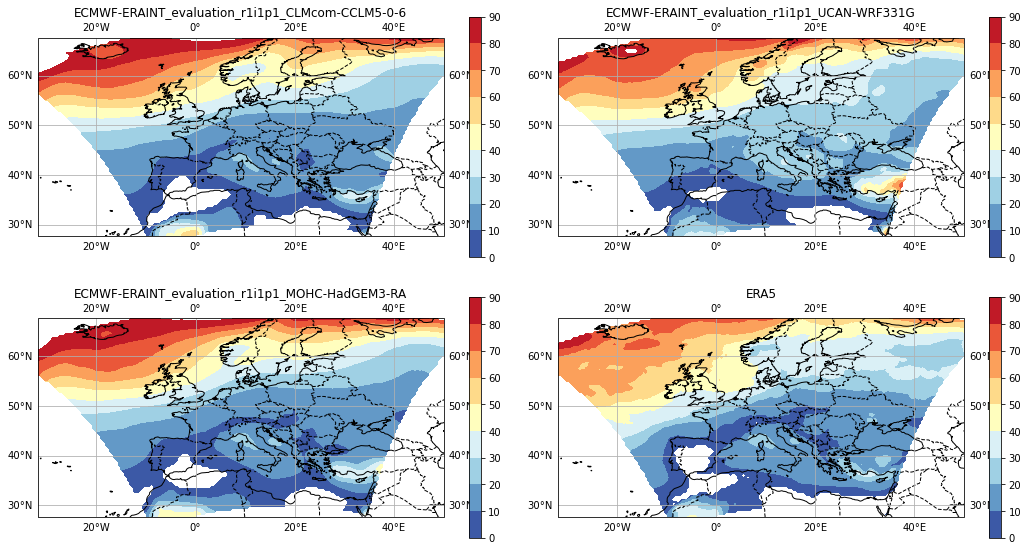

evaluation Anticyclones


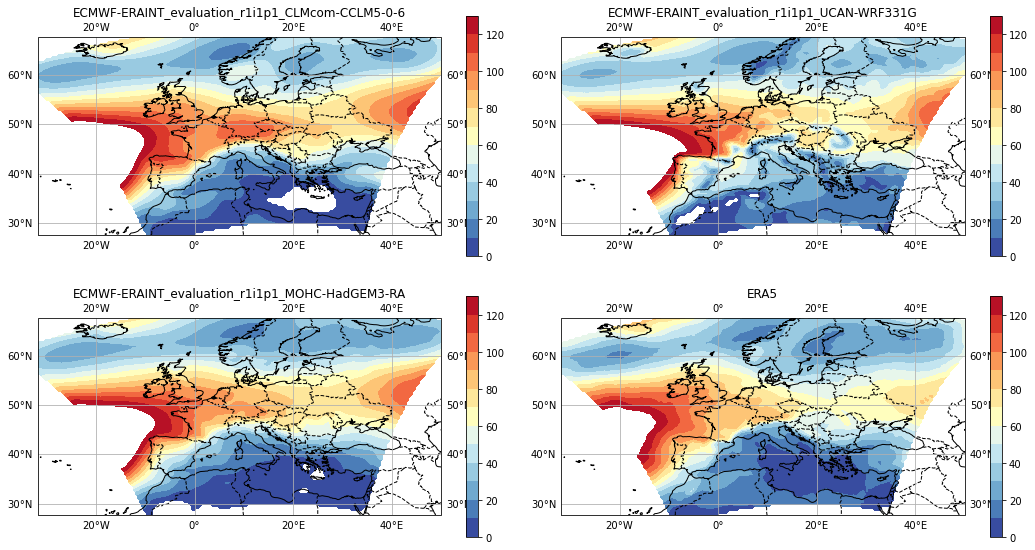

evaluation Precipitation


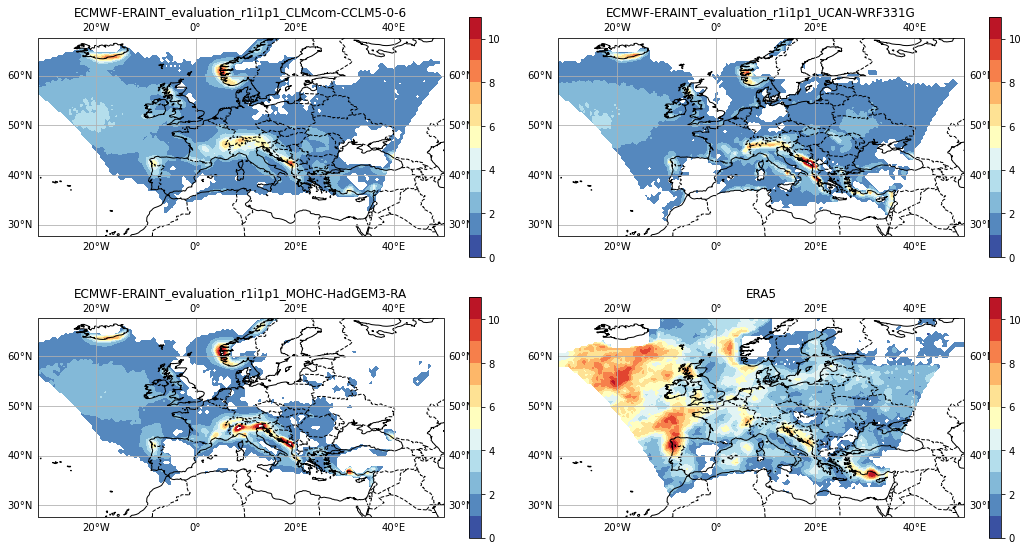

evaluation Anviles


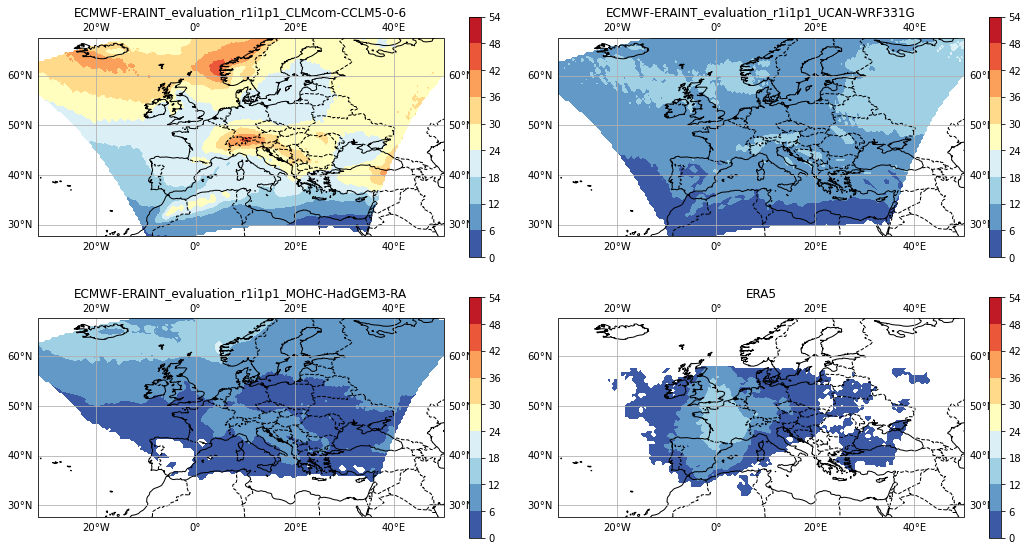

evaluation Fronts


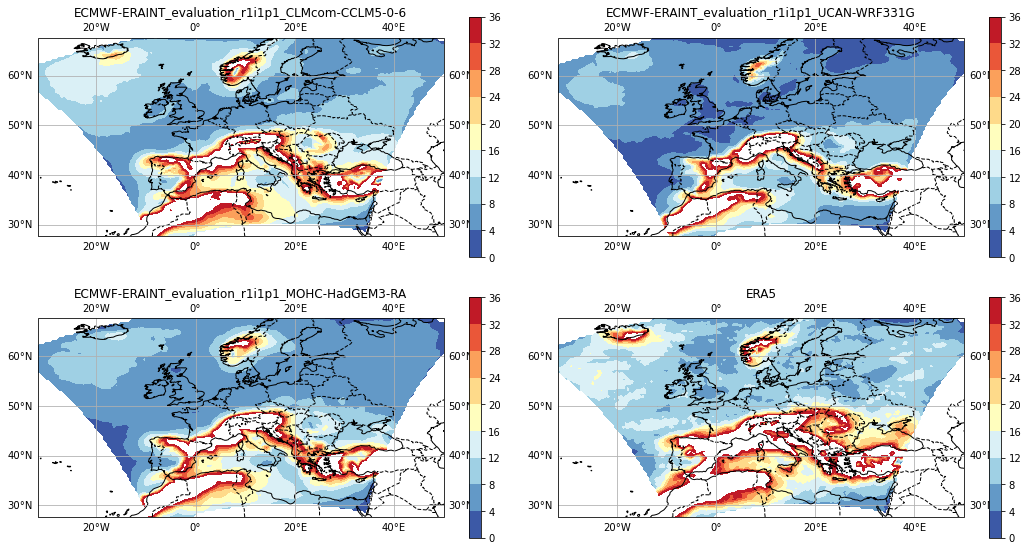

evaluation AR


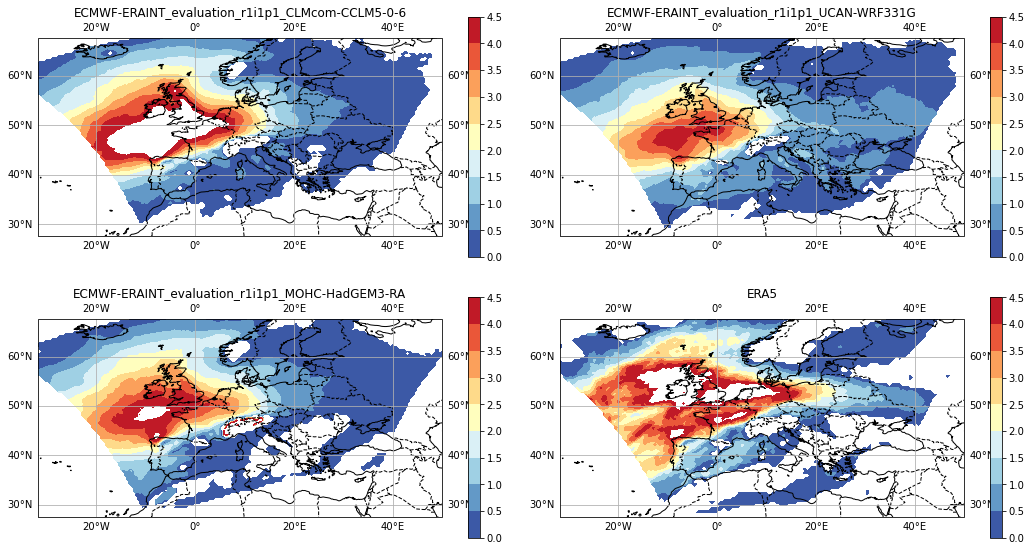

evaluation MS


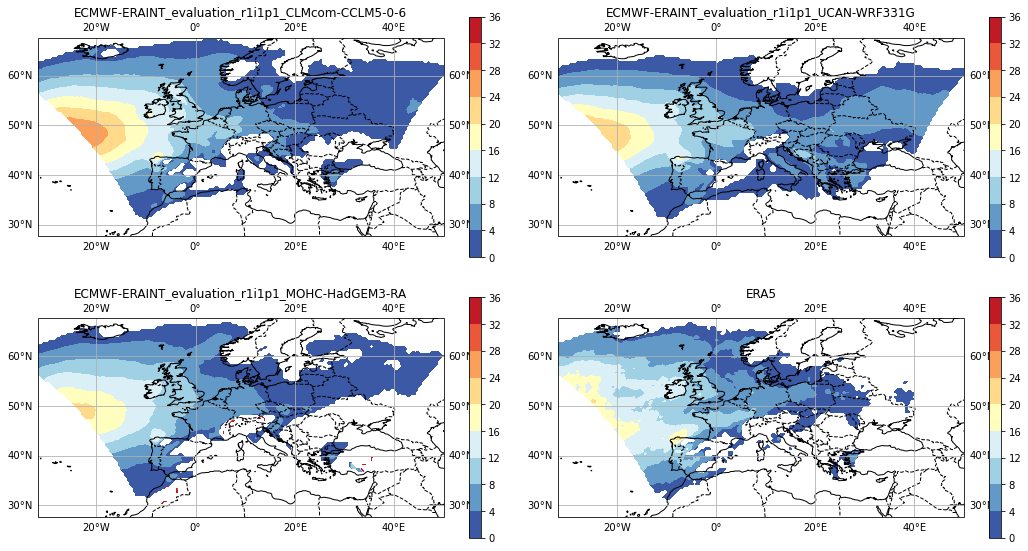

evaluation Cyclones diff from ERA5 %


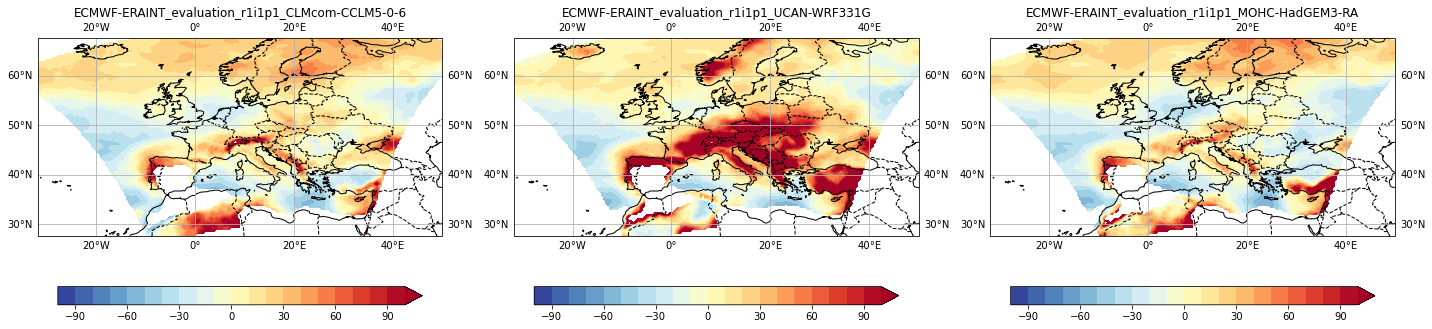

evaluation Anticyclones diff from ERA5 %


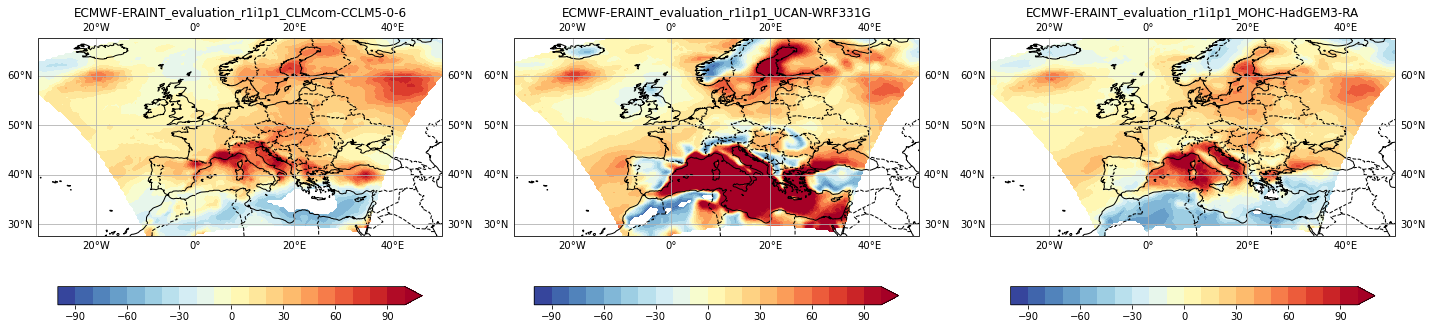

evaluation Precipitation diff from ERA5 %


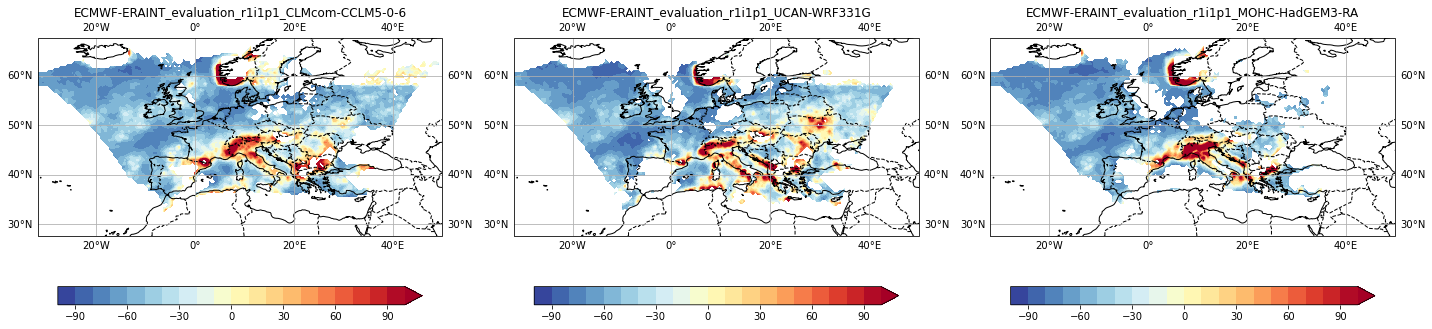

evaluation Anviles diff from ERA5 %


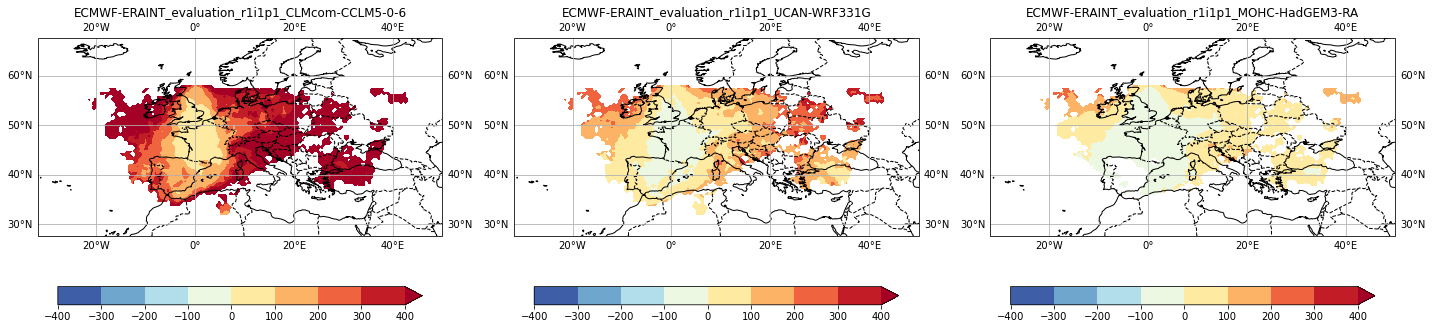

evaluation Fronts diff from ERA5 %


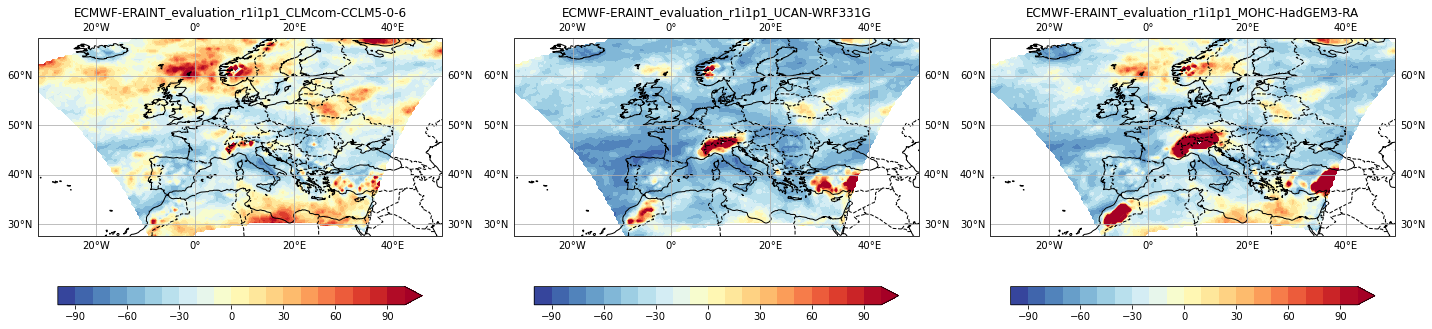

evaluation AR diff from ERA5 %


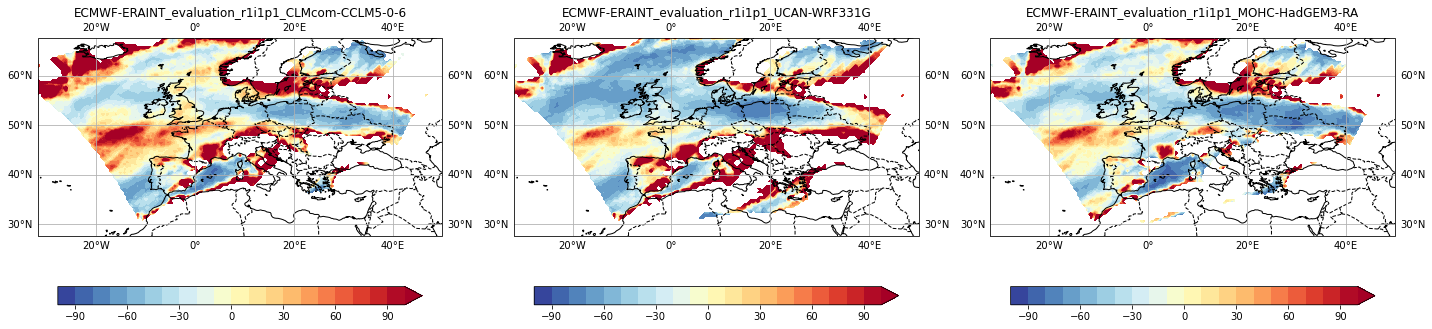

evaluation MS diff from ERA5 %


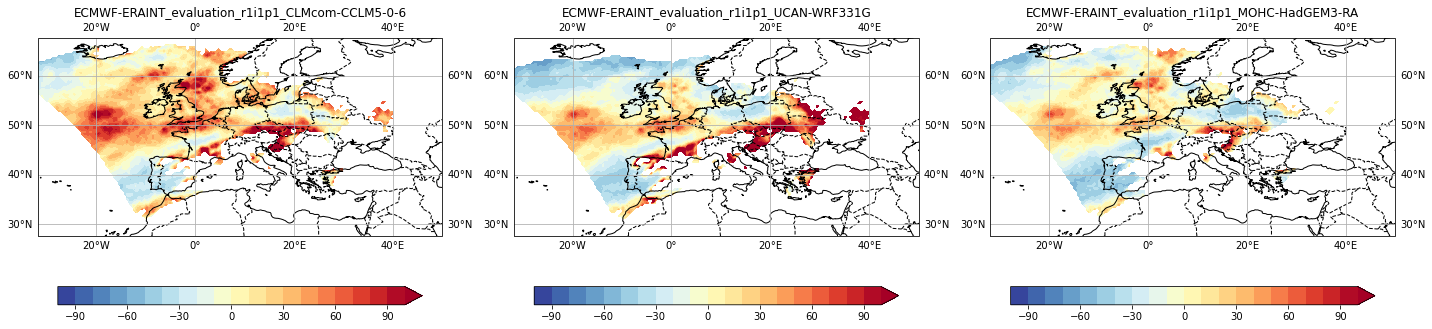

historical Cyclones


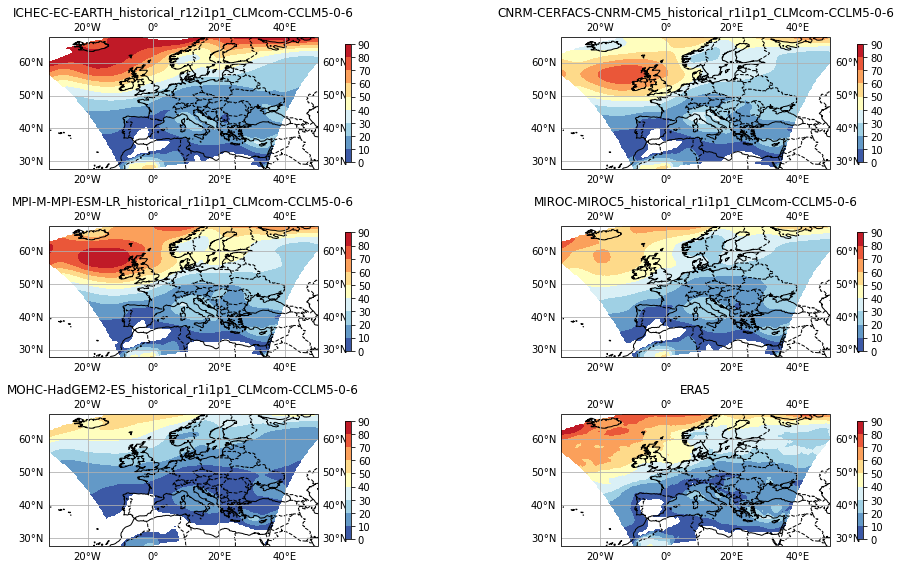

historical Anticyclones


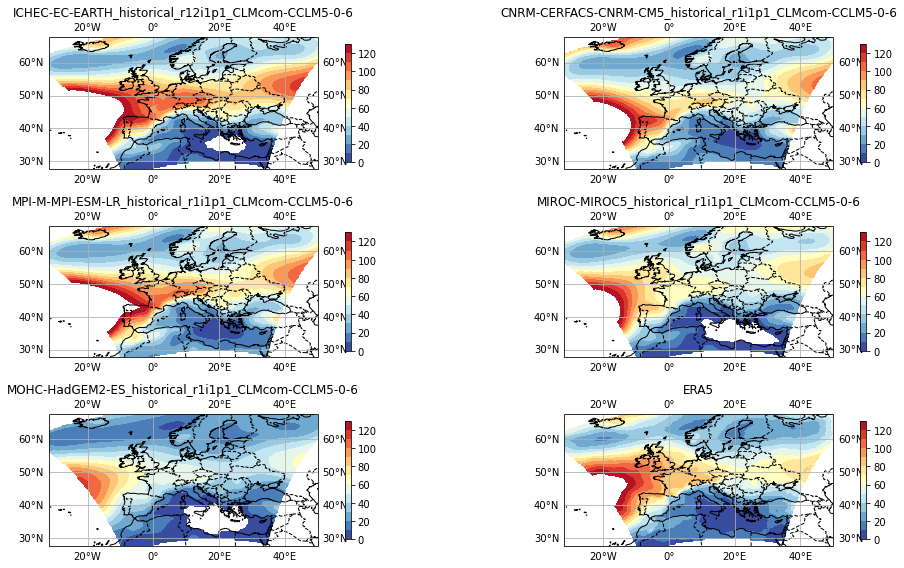

historical Precipitation


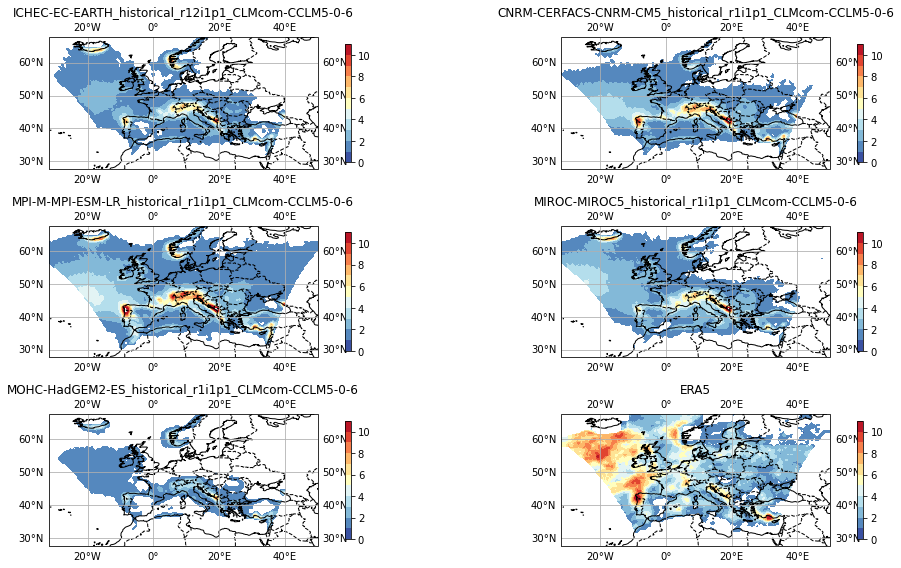

historical Anviles


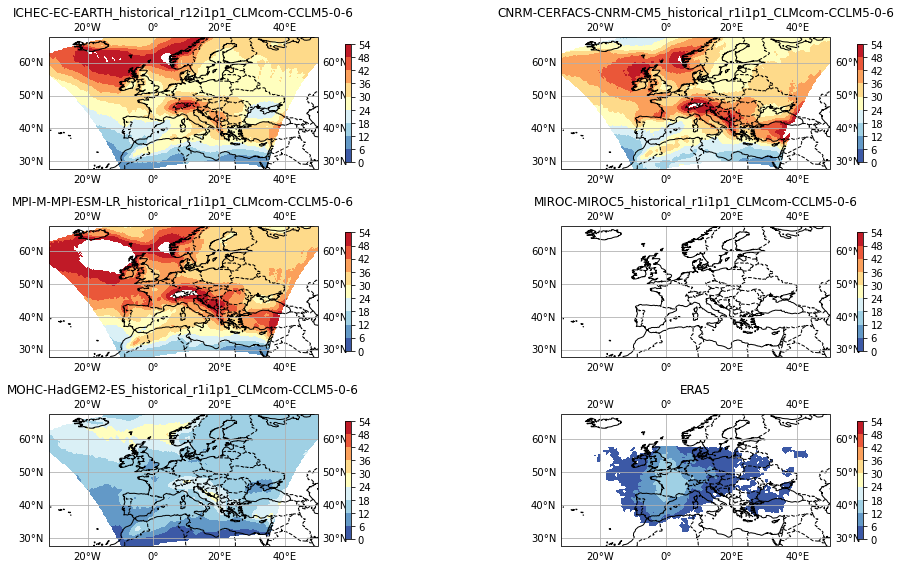

historical Fronts


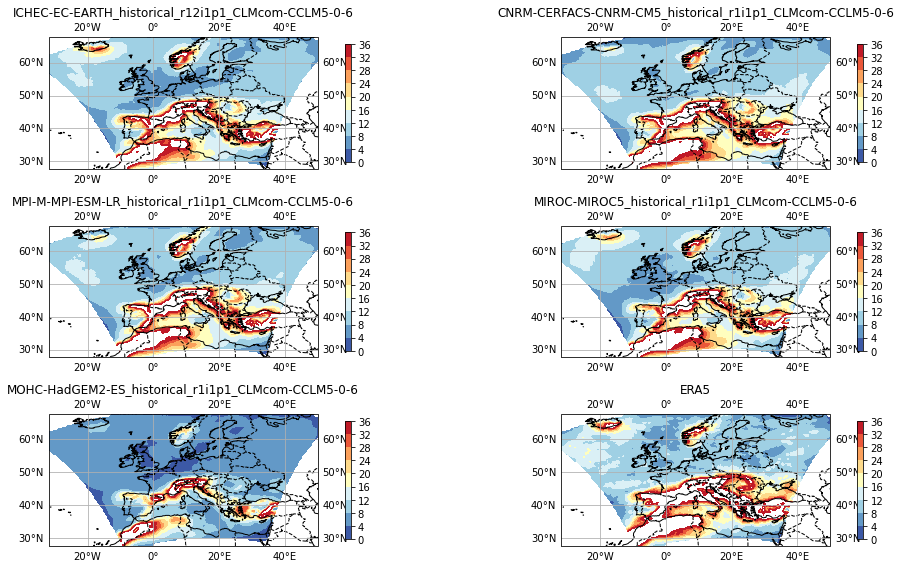

historical AR


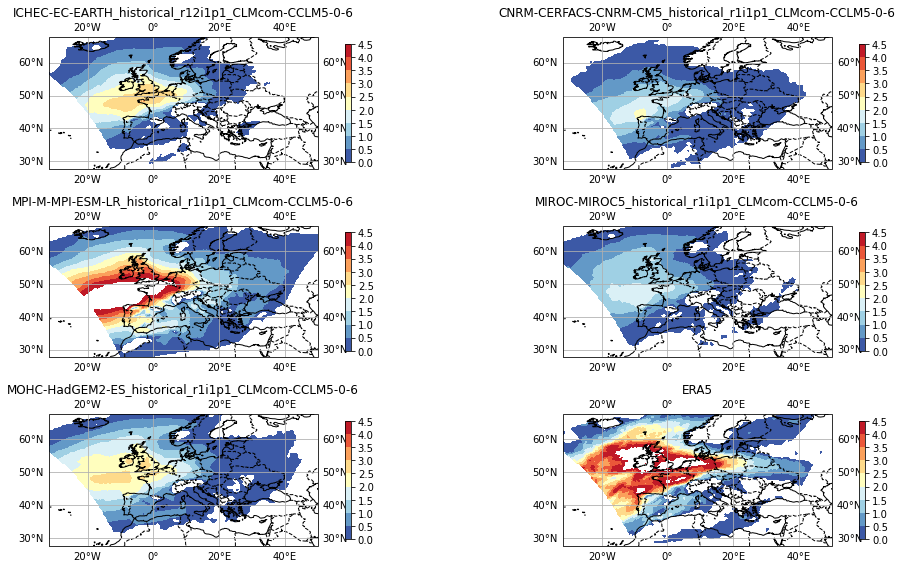

historical MS


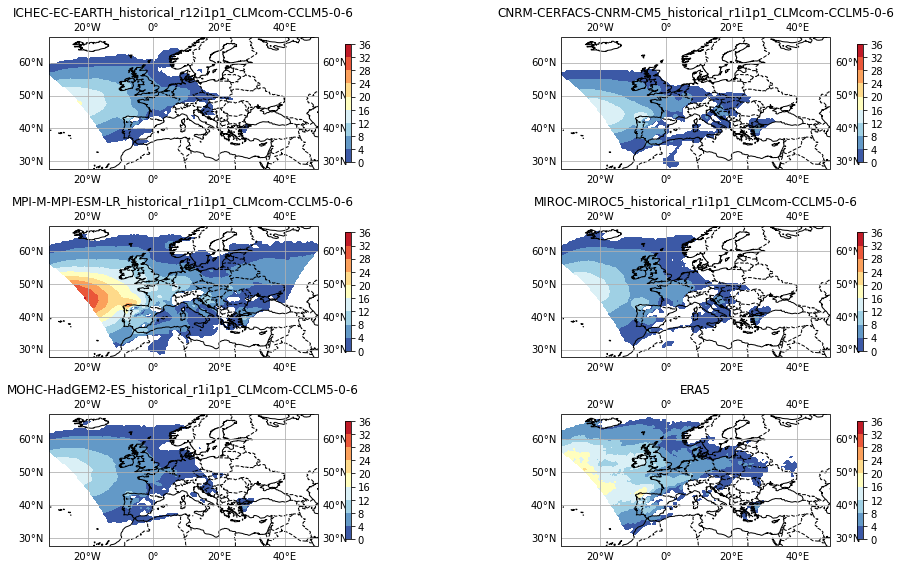

historical Cyclones diff from ERA5 %


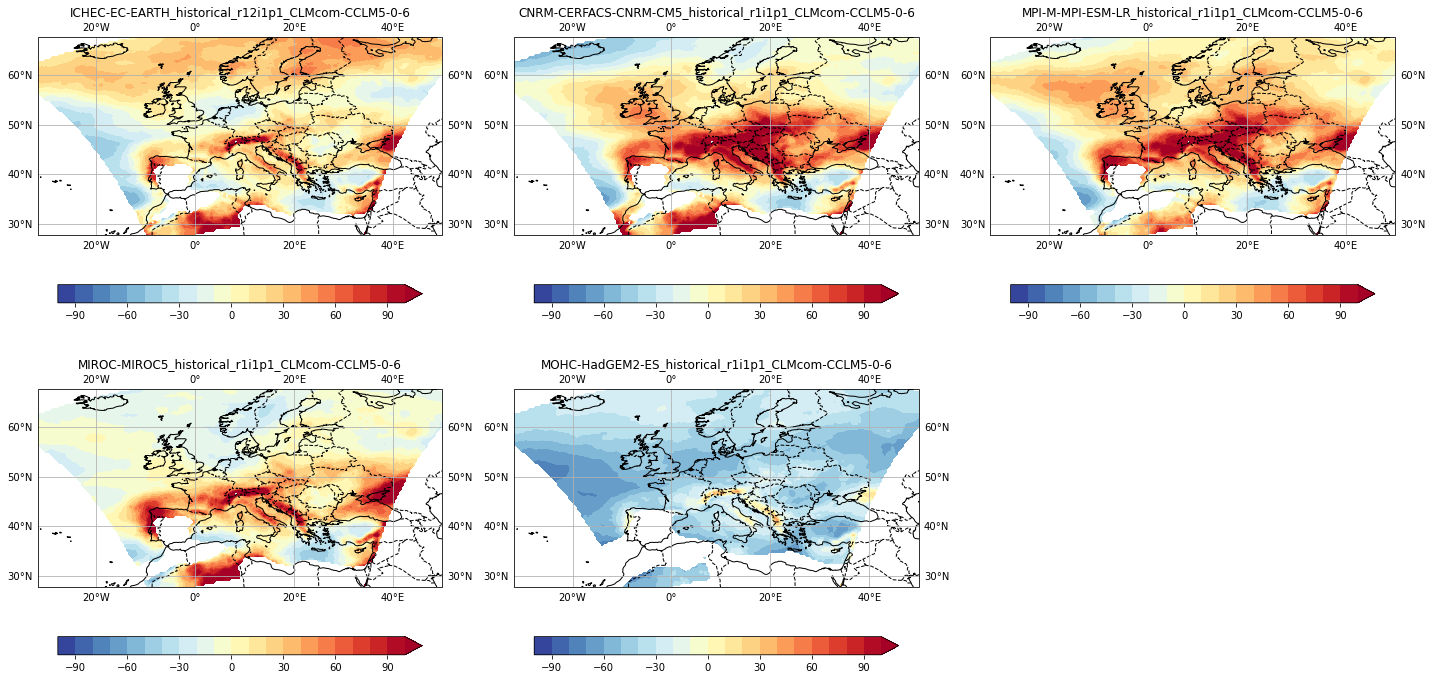

historical Anticyclones diff from ERA5 %


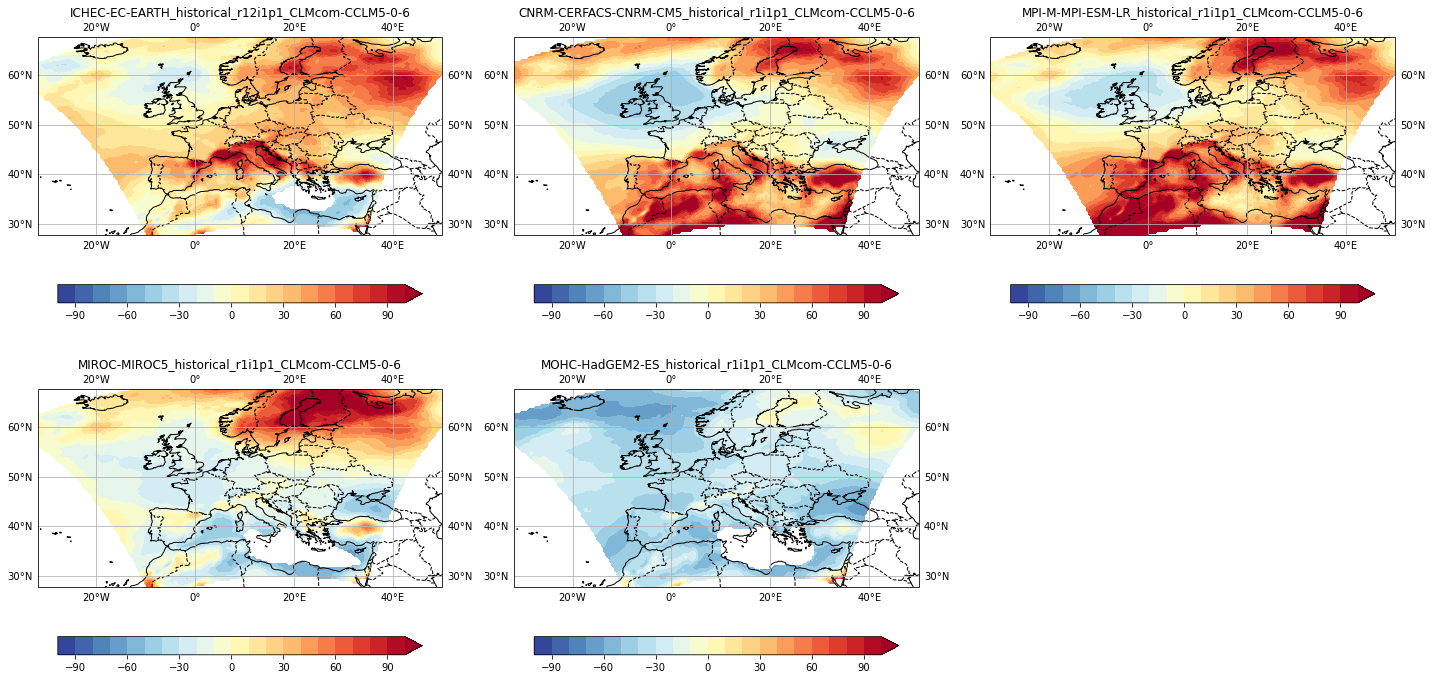

historical Precipitation diff from ERA5 %


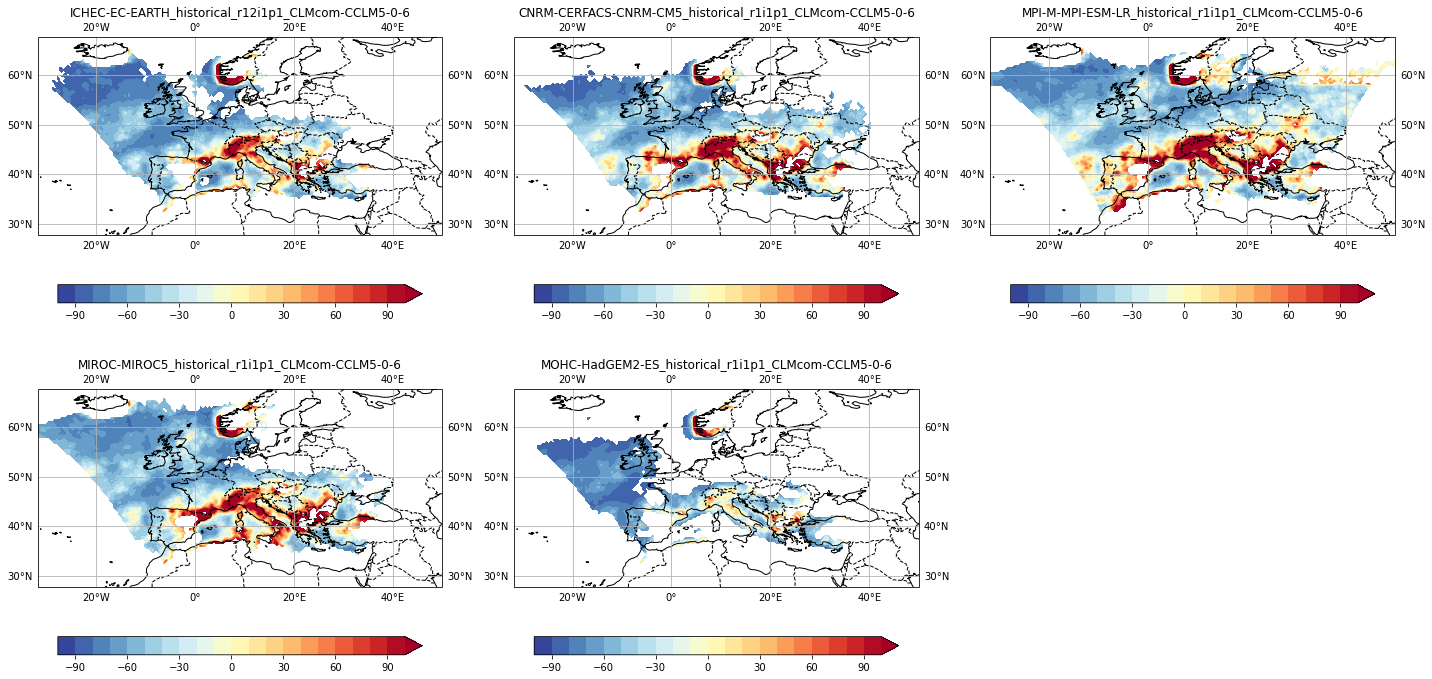

historical Anviles diff from ERA5 %


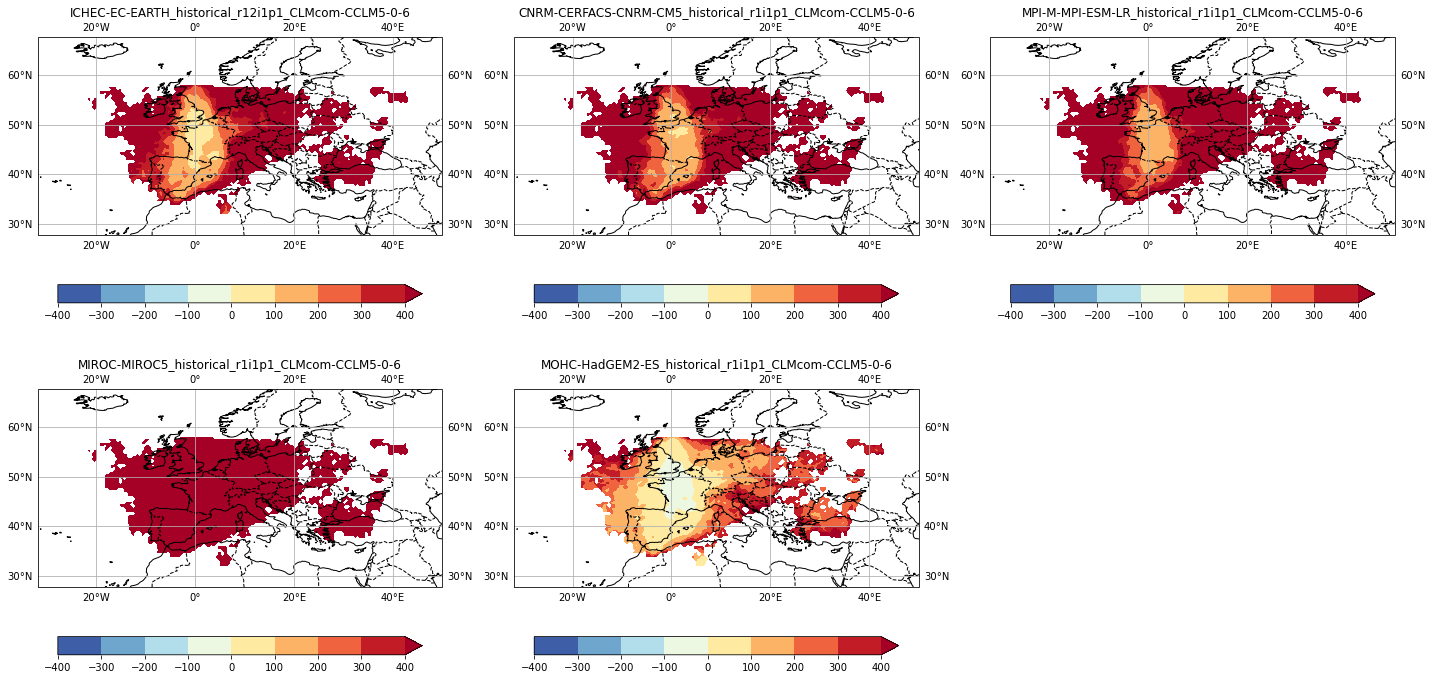

historical Fronts diff from ERA5 %


In [ ]:
for ds_type in type_s:
    dataset, ObjectFrequency = read_objs('44', '44', nx, ny, ds_type)
    # append era5 object at the end of dataset 
    ObjectFrequency = np.append(ObjectFrequency, ObjectFrequency_era, axis = 0)  
    dataset.append('ERA5')
    n_ds = ObjectFrequency.shape[0]
     
    plot_obj('44', ds_type, dataset, ObjectFrequency)
    
    for nd in range(n_ds-1):
        ObjectFrequency[nd,:,:,:] = (ObjectFrequency[nd,:,:,:] - ObjectFrequency[-1]) \
                                    / ObjectFrequency[-1] * 100      
    
    plot_obj_diff_44('44', ds_type, dataset[:-1], ObjectFrequency[:-1])
    